### Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


По результатам изучения общей информации можно сделать следующие выводы:  
- Количество строк в столбцах не различается. Значит, в данных нет пропущенных значений. 
- В данных присутствуют некорректные названия столбцов и некорректный тип данных в столбце `EventTimestamp`, которые нужно исправить.

### Подготовим данные
#### Заменим названия столбцов.

In [4]:
data = data.rename(columns={
                            'EventName':'event_name',
                            'DeviceIDHash':'device_id_hash',
                            'EventTimestamp':'event_timestamp',
                            'ExpId':'exp_id'
                            })
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

#### Преобразуем данные в нужные типы.

In [5]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


#### Проверим данные на пропуски.

In [6]:
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

В данных отсутствуют пропуски.

#### Проверим данные на явные и неявные дубликаты.

In [7]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 413


Так как явных дубликатов относительно мало, удалим их.

In [8]:
data = data.drop_duplicates()
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


In [9]:
# проверка неявных дубликатов в столбце с событиями
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В данных отсутствуют неявные дубликаты.

#### Добавим отдельный столбец дат.

In [10]:
data['event_date'] = pd.to_datetime(data['event_timestamp'].dt.date)
data['event_date'] = data['event_date'].dt.strftime('%Y-%m-%d')
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Изучим и проверим данные
#### Изучим, сколько всего событий в логе.

In [11]:
print('Общее количество событий в логе:', len(data['event_name']))

Общее количество событий в логе: 243713


In [12]:
print('Количество уникальных событий в логе:', len(data['event_name'].unique()))

Количество уникальных событий в логе: 5


In [13]:
print('Количество записей по событиям:')
data['event_name'].value_counts()

Количество записей по событиям:


event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64

#### Изучим, сколько всего пользователей в логе.

In [14]:
print('Количество уникальных пользователей в логе:', data['device_id_hash'].nunique())

Количество уникальных пользователей в логе: 7551


#### Изучим, сколько в среднем событий приходится на пользователя.

In [15]:
print('Среднее количество событий на пользователя:', data.groupby('device_id_hash')['event_name'].count().mean().round(2))

Среднее количество событий на пользователя: 32.28


#### Изучим, данными за какой период мы располагаем.

In [16]:
print('Дата первого события:', data['event_date'].min())
print('Дата последнего события:', data['event_date'].max())

Дата первого события: 2019-07-25
Дата последнего события: 2019-08-07


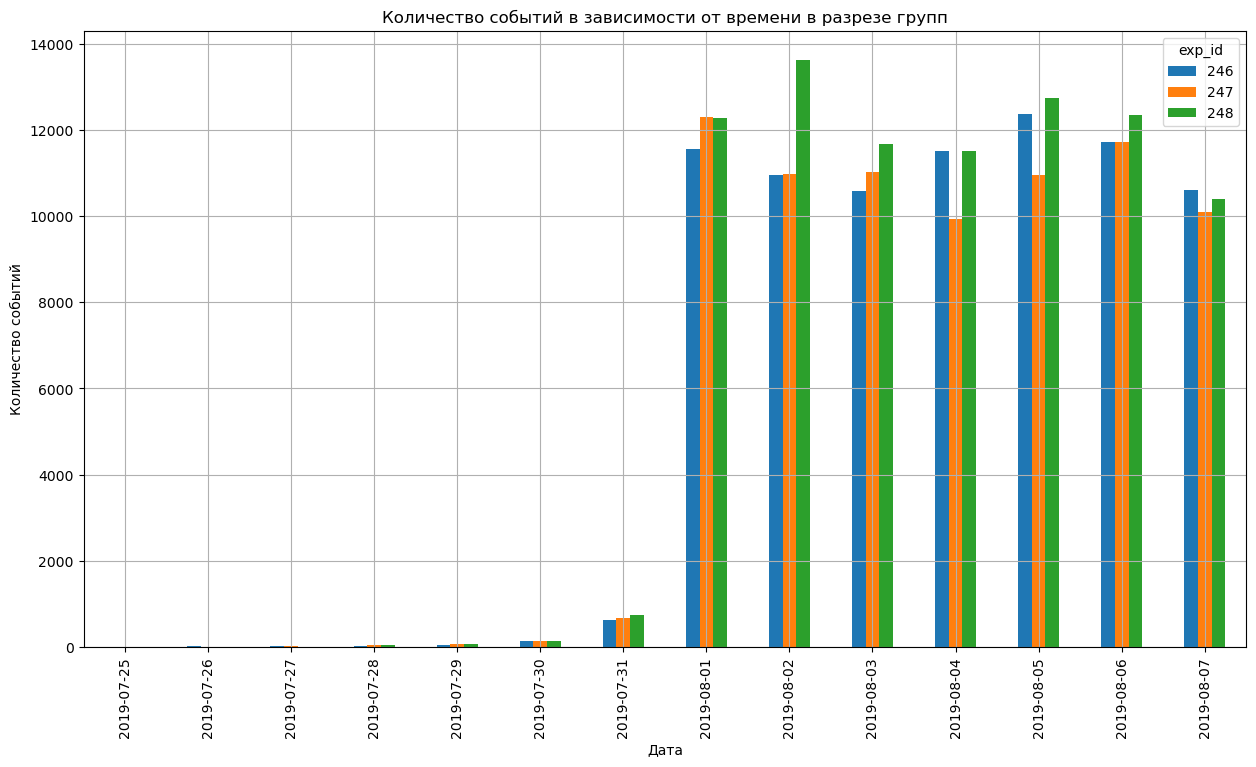

In [17]:
(data
 .pivot_table(index='event_date', columns='exp_id', values='event_name', aggfunc='count')
 .plot(kind='bar', figsize=(15, 8), legend=True, grid=True)
)
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий');

График показывает, что не за весь период у нас одинаково полные данные. По некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».  
На самом деле мы располагаем данными за период с 1 по 7 августа. Отбросим старые данные.

In [18]:
actual_data = data[data['event_date'] >= '2019-08-01']
print('Дата первого события за актуальный период:', actual_data['event_date'].min())
print('Дата последнего события за актуальный период:', actual_data['event_date'].max())

Дата первого события за актуальный период: 2019-08-01
Дата последнего события за актуальный период: 2019-08-07


#### Проверим, много ли событий и пользователей мы потеряли, отбросив старые данные.

In [19]:
print('Количество потерянных событий:', len(data['event_name'])-len(actual_data['event_name']))
print('Количество потерянных пользователей:', data['device_id_hash'].nunique()-actual_data['device_id_hash'].nunique())
print('Относительные потери событий:', round((len(data['event_name'])-len(actual_data['event_name']))/len(data['event_name']), 3))
print('Относительные потери пользователей:', round((data['device_id_hash'].nunique()-actual_data['device_id_hash'].nunique())/data['device_id_hash'].nunique(), 3))

Количество потерянных событий: 2826
Количество потерянных пользователей: 17
Относительные потери событий: 0.012
Относительные потери пользователей: 0.002


Относительные потери событий и пользователей составляют меньше 2%.

#### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [20]:
print('Количество пользователей по экспериментальным группам:')
actual_data.groupby('exp_id').agg({'device_id_hash': 'nunique'})

Количество пользователей по экспериментальным группам:


,device_id_hash
exp_id,
246,2484
247,2513
248,2537


В данных за актуальный период у нас есть пользователи из всех трёх экспериментальных групп.

### Изучим воронку событий
#### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

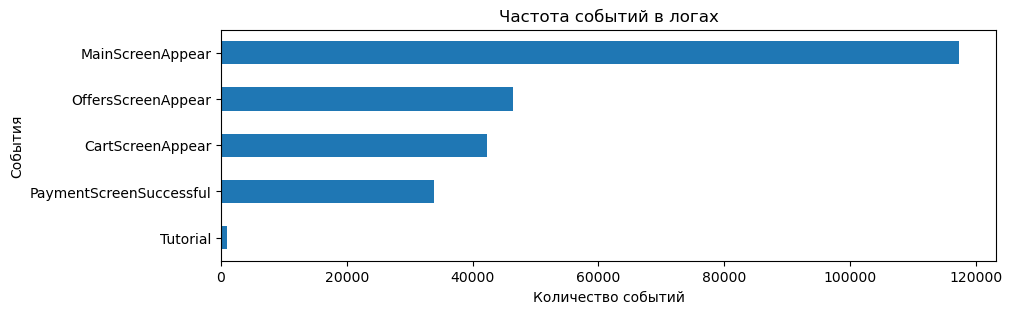

In [21]:
(actual_data
 .groupby('event_name').agg({'device_id_hash': 'count'})
 .sort_values(by='device_id_hash', ascending=True)
 .plot(kind = 'barh', figsize=(10, 3), legend=False)
)
plt.title('Частота событий в логах')
plt.xlabel('Количество событий')
plt.ylabel('События');

Чаще всего в логах встречается событие MainScreenAppear, затем идут события OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.

#### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [22]:
users_count = actual_data.groupby('event_name').agg(users=('device_id_hash', 'nunique'))
users_count['ratio']=round(users_count['users']/actual_data['device_id_hash'].nunique(), 3)
users_count = users_count.sort_values(by='ratio', ascending=False).reset_index()
users_count

,event_name,users,ratio
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


При подсчете количества пользователей по событиям ситуация такая же: чаще всего встречается событие MainScreenAppear, затем идут события OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.

#### Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Не будем их учитывать при расчёте воронки.

Можно предположить, что события происходят в следующем порядке:  
MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful  
Событие Tutorial выбивается из этой цепочки, это наименее частое событие, поэтому не будем учитывать его при расчете воронки.

In [23]:
users_count = users_count.query('event_name != "Tutorial"')
users_count

,event_name,users,ratio
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470


#### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [24]:
print('Доля пользователей, которая прошла с шага MainScreenAppear на OffersScreenAppear:', round(int(users_count[users_count['event_name'] == 'OffersScreenAppear']['users']) / int(users_count[users_count['event_name'] == 'MainScreenAppear']['users'])*100),'%')
print('Доля пользователей, которая прошла с шага OffersScreenAppear на CartScreenAppear:', round(int(users_count[users_count['event_name'] == 'CartScreenAppear']['users']) / int(users_count[users_count['event_name'] == 'OffersScreenAppear']['users'])*100),'%')
print('Доля пользователей, которая прошла с шага CartScreenAppear на PaymentScreenSuccessful:', round(int(users_count[users_count['event_name'] == 'PaymentScreenSuccessful']['users']) / int(users_count[users_count['event_name'] == 'CartScreenAppear']['users'])*100),'%')

Доля пользователей, которая прошла с шага MainScreenAppear на OffersScreenAppear: 62 %
Доля пользователей, которая прошла с шага OffersScreenAppear на CartScreenAppear: 81 %
Доля пользователей, которая прошла с шага CartScreenAppear на PaymentScreenSuccessful: 95 %


/var/folders/nh/pz2rjlzx14ld7ljqbx27n70w0000gn/T/ipykernel_63766/3869790611.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('Доля пользователей, которая прошла с шага MainScreenAppear на OffersScreenAppear:', round(int(users_count[users_count['event_name'] == 'OffersScreenAppear']['users']) / int(users_count[users_count['event_name'] == 'MainScreenAppear']['users'])*100),'%')
/var/folders/nh/pz2rjlzx14ld7ljqbx27n70w0000gn/T/ipykernel_63766/3869790611.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('Доля пользователей, которая прошла с шага OffersScreenAppear на CartScreenAppear:', round(int(users_count[users_count['event_name'] == 'CartScreenAppear']['users']) / int(users_count[users_count['event_name'] == 'OffersScreenAppear']['users'])*100),'%')
/var/folders/nh/pz2rjlzx14ld7ljq

#### Изучим, на каком шаге теряются больше всего пользователей.

При переходе с MainScreenAppear на OffersScreenAppear теряется больше всего пользователей (примерно 38%).

#### Изучим, какая доля пользователей доходит от первого события до оплаты.

In [25]:
print('Доля пользователей, которая прошла от первого события до оплаты:', round(int(users_count[users_count['event_name'] == 'PaymentScreenSuccessful']['users']) / int(users_count[users_count['event_name'] == 'MainScreenAppear']['users'])*100),'%')

Доля пользователей, которая прошла от первого события до оплаты: 48 %


/var/folders/nh/pz2rjlzx14ld7ljqbx27n70w0000gn/T/ipykernel_63766/4003201578.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('Доля пользователей, которая прошла от первого события до оплаты:', round(int(users_count[users_count['event_name'] == 'PaymentScreenSuccessful']['users']) / int(users_count[users_count['event_name'] == 'MainScreenAppear']['users'])*100),'%')


По результатам изучения воронки событий можно сделать следующие выводы:  
- Чаще всего в логах встречается событие MainScreenAppear, затем идут события OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.
- Мы предположили, что события происходят в следующем порядке: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful. Событие Tutorial выбивается из этой цепочки, это наименее частое событие, поэтому мы не учитывали его при расчете воронки.
- При переходе с события MainScreenAppear на OffersScreenAppear теряется больше всего пользователей (примерно 38%).
- Доля пользователей, которая прошла от первого события до оплаты составляет 48%.

Рекомендуем обратить внимание на высокий процент потерь пользователей при переходе с события MainScreenAppear на событие OffersScreenAppear. После улучшения перехода на это событие доля пользователей, дошедших до оплаты, может увеличиться.

### Изучим результаты эксперимента
#### Изучим, сколько пользователей в каждой экспериментальной группе.

Посчитаем количество уникальных пользователей в каждой группе.

In [26]:
users_in_groups = actual_data.pivot_table(index='exp_id', values='device_id_hash', aggfunc={'nunique'}).reset_index()
users_in_groups

,exp_id,nunique
0,246,2484
1,247,2513
2,248,2537


Проверим, нет ли в данных пользователей, участвовавших в нескольких группах теста одновременно.

In [27]:
users_246 = actual_data[actual_data['exp_id'] == 246]['device_id_hash'].unique()
users_247 = actual_data[actual_data['exp_id'] == 247]['device_id_hash'].unique()
users_248 = actual_data[actual_data['exp_id'] == 248]['device_id_hash'].unique()
print('Количество пользователей, участвовавших одновременно в группах 246 и 247:', len(set(users_246) & set(users_247)))
print('Количество пользователей, участвовавших одновременно в группах 247 и 248:', len(set(users_247) & set(users_248)))
print('Количество пользователей, участвовавших одновременно в группах 246 и 248:', len(set(users_246) & set(users_248)))

Количество пользователей, участвовавших одновременно в группах 246 и 247: 0
Количество пользователей, участвовавших одновременно в группах 247 и 248: 0
Количество пользователей, участвовавших одновременно в группах 246 и 248: 0


#### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.  

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. 

In [28]:
events_groups = actual_data.pivot_table(index=['event_name', 'exp_id'], values='device_id_hash', aggfunc={'nunique'}).reset_index()
events_groups = events_groups.query('event_name != "Tutorial"')
events_groups.query('exp_id	!= 248').sort_values(by='nunique', ascending=False).head(2)

,event_name,exp_id,nunique
4,MainScreenAppear,247,2476
3,MainScreenAppear,246,2450


In [29]:
print('Доля пользователей в группе 246, совершивших событие MainScreenAppear:', round(int(events_groups.query('exp_id == 246 & event_name == "MainScreenAppear"')['nunique']) / int(users_in_groups.query('exp_id == 246')['nunique']), 3))
print('Доля пользователей в группе 247, совершивших событие MainScreenAppear:', round(int(events_groups.query('exp_id == 247 & event_name == "MainScreenAppear"')['nunique']) / int(users_in_groups.query('exp_id == 247')['nunique']), 3))

Доля пользователей в группе 246, совершивших событие MainScreenAppear: 0.986
Доля пользователей в группе 247, совершивших событие MainScreenAppear: 0.985


/var/folders/nh/pz2rjlzx14ld7ljqbx27n70w0000gn/T/ipykernel_63766/219834676.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('Доля пользователей в группе 246, совершивших событие MainScreenAppear:', round(int(events_groups.query('exp_id == 246 & event_name == "MainScreenAppear"')['nunique']) / int(users_in_groups.query('exp_id == 246')['nunique']), 3))
/var/folders/nh/pz2rjlzx14ld7ljqbx27n70w0000gn/T/ipykernel_63766/219834676.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('Доля пользователей в группе 247, совершивших событие MainScreenAppear:', round(int(events_groups.query('exp_id == 247 & event_name == "MainScreenAppear"')['nunique']) / int(users_in_groups.query('exp_id == 247')['nunique']), 3))


Проверим, будет ли отличие между группами статистически достоверным с помощью отдельной функции. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

Для проверки гипотезы о равенстве долей будем использовать z-тест. Установим уровень значимости 0.05. Так как будет проведена множественная проверка гипотез, то для коррекции уровня значимости используем поправку Бонферрони.

Сформулируем гипотезы.  
Нулевая: нет оснований считать доли разными.  
Альтернативная: между долями есть значимая разница.  

In [30]:
def stat_function(data1, data2, event_name, alpha, n):
    
    # считаем поправку Бонферрони
    alpha_bonf = alpha / n
    
    #число пользователей в 1 и 2 группе
    users = np.array([data1['device_id_hash'].nunique(), 
                        data2['device_id_hash'].nunique()])
    
    # число пользователей, которые совершили событие в 1 и 2 группе
    event = np.array([data1[data1['event_name'] == event_name]['device_id_hash'].nunique(), 
                        data2[data2['event_name'] == event_name]['device_id_hash'].nunique()])
    
    # пропорция событий в первой группе:
    p1 = event[0]/users[0]

    # пропорция событий во второй группе:
    p2 = event[1]/users[1]

    # пропорция событий в комбинированном датасете:
    p_combined = (event[0] + event[1]) / (users[0] + users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha_bonf:
        print('Отвергаем нулевую гипотезу: между долями в событии', event_name, 'есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии', event_name, 'разными')

In [31]:
for event_name in users_count['event_name'].unique():
    stat_function(actual_data[actual_data['exp_id'] == 246], actual_data[actual_data['exp_id'] == 247], event_name, .05, 16)
    print()

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии MainScreenAppear разными

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии OffersScreenAppear разными

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии CartScreenAppear разными

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии PaymentScreenSuccessful разными



Анализ результатов A/A-теста сообщает, что нет оснований считать доли в событиях разными. Значит, разбиение на группы работает корректно.

#### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Сформулируем гипотезы.  
Нулевая: нет оснований считать доли разными.  
Альтернативная: между долями есть значимая разница.

In [32]:
for event_name in users_count['event_name'].unique():
    stat_function(actual_data[actual_data['exp_id'] == 246], actual_data[actual_data['exp_id'] == 248], event_name, .05, 16)
    print()

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии MainScreenAppear разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии OffersScreenAppear разными

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии CartScreenAppear разными

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии PaymentScreenSuccessful разными



Анализ результатов A/B-теста для групп 246 и 248 сообщает, что нет оснований считать доли в событиях разными.

In [33]:
for event_name in users_count['event_name'].unique():
    stat_function(actual_data[actual_data['exp_id'] == 247], actual_data[actual_data['exp_id'] == 248], event_name, .05, 16)
    print()

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии MainScreenAppear разными

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии OffersScreenAppear разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии CartScreenAppear разными

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии PaymentScreenSuccessful разными



Анализ результатов A/B-теста для групп 247 и 248 сообщает, что нет оснований считать доли в событиях разными.

In [34]:
for event_name in users_count['event_name'].unique():
    stat_function(actual_data[actual_data['exp_id'] != 248], actual_data[actual_data['exp_id'] == 248], event_name, .05, 16)
    print()

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии MainScreenAppear разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии OffersScreenAppear разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии CartScreenAppear разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии PaymentScreenSuccessful разными



Анализ результатов A/B-теста для объединенной группы 246+247 и группы 248 сообщает, что нет оснований считать доли в событиях разными.

#### Какой уровень значимости был выбран при проверке статистических гипотез выше? Посчитаем, сколько проверок статистических гипотез мы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить?

При проверке статистических гипотез выше был выбран уровень значимости 0.05. Мы провели 16 проверок статистических гипотез. Проведем проверку гипотез при уровне значимости 0.1.

Сформулируем гипотезы.  
Нулевая: нет оснований считать доли разными.  
Альтернативная: между долями есть значимая разница.

In [35]:
for event_name in users_count['event_name'].unique():
    stat_function(actual_data[actual_data['exp_id'] == 246], actual_data[actual_data['exp_id'] == 248], event_name, .1, 16)
    print()

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии MainScreenAppear разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии OffersScreenAppear разными

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии CartScreenAppear разными

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии PaymentScreenSuccessful разными



Анализ результатов A/B-теста для групп 246 и 248 при уровне значимости 0.1 сообщает, что нет оснований считать доли в событиях разными.

In [36]:
for event_name in users_count['event_name'].unique():
    stat_function(actual_data[actual_data['exp_id'] == 247], actual_data[actual_data['exp_id'] == 248], event_name, .1, 16)
    print()

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии MainScreenAppear разными

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии OffersScreenAppear разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии CartScreenAppear разными

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии PaymentScreenSuccessful разными



Анализ результатов A/B-теста для групп 247 и 248 при уровне значимости 0.1 сообщает, что нет оснований считать доли в событиях разными.

In [37]:
for event_name in users_count['event_name'].unique():
    stat_function(actual_data[actual_data['exp_id'] != 248], actual_data[actual_data['exp_id'] == 248], event_name, .1, 16)
    print()

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии MainScreenAppear разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии OffersScreenAppear разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии CartScreenAppear разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в событии PaymentScreenSuccessful разными



Анализ результатов A/B-теста для объединенной группы 246+247 и группы 248 при уровне значимости 0.1 сообщает, что нет оснований считать доли в событиях разными. Увеличение уровня значимости до 0.1 не повлияло на результаты проверок статистических гипотез.

### Общий вывод

Задачей исследования было изучить воронку продаж и результаты A/A/B-эксперимента для 2 контрольных групп со старыми шрифтами и одной экспериментальной группы с новыми шрифтами. В результате исследования были получены следующие выводы:
- Данные представлены за период с 25 июля по 7 августа 2019 года. Не за весь период содержатся одинаково полные данные, поэтому исследование было ограничено периодом с 1 по 7 августа. Относительные потери событий и пользователей при этом составили меньше 2%.
- Чаще всего в логах встречается событие MainScreenAppear, затем идут события OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.
- Мы предположили, что события происходят в следующем порядке: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful. Событие Tutorial выбивается из этой цепочки, это наименее частое событие, поэтому мы не учитывали его при расчете воронки.
- При переходе с события MainScreenAppear на OffersScreenAppear теряется больше всего пользователей (примерно 38%).
- Доля пользователей, которая прошла от первого события до оплаты составляет 48%.
- Анализ результатов A/A-теста двух контрольных групп показал, что нет оснований считать доли в событиях разными. Значит, разбиение на группы 246 и 247 работает корректно.
- Анализ результатов A/B-теста 2 контрольных групп со старыми шрифтами и одной экспериментальной группы с новыми шрифтами показал, что нет оснований считать доли в событиях разными. Значит, изменение шрифта не повлияло на поведение пользователей.